In [1]:
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model 

# Debido a que puede haber más de un agente por celda elegimos `MultiGrid` que permite más de un objeto por celda.
from mesa.space import MultiGrid

# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, BoundaryNorm
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

# Para sumar tuplas
import operator

In [2]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell

        if len(cell_content) == 0:
          if x == 4 or x == 5 or y == 4 or y == 5:
              grid[x][y] = 7
          else:
              grid[x][y] = 8
        else:
          for content in cell_content:
            if isinstance(content, Semaforo):
              grid[x][y] = content.estado + 4
            elif isinstance(content, CarrilInterseccion):
              grid[x][y] = 7
            elif isinstance(content, Carro):
                grid[x][y] = content.numCarril
            
    return grid

class Carro(Agent):
    def __init__(self, unique_id, model, numCarril, direccionCarril, destino, posFinal, semaforo, posInicial):
      super().__init__(unique_id, model)
      self.numCarril = numCarril
      self.direccionCarril = direccionCarril
      self.destino = destino
      self.posFinal = posFinal
      self.semaforo = semaforo
      self.next_position = posInicial
      self.cruzo = False

    def checaIntersection(self):
      cellmates = self.model.grid.get_cell_list_contents([self.pos])
      for i in cellmates:
        if type(i) == CarrilInterseccion and self.numCarril == i.numCarril:
          self.cruzo = True
          self.direccionCarril = i.vueltaDerecha
          self.posFinal = self.model.posicionesFinalesVuelta[self.numCarril]
          self.semaforo = None

    def step(self):
      move = True

      if self.destino == 1:
        self.checaIntersection()

      possible_next_position = tuple(map(operator.add, self.pos, self.direccionCarril))
      if self.pos != self.posFinal:
        ver_semaforo = True if len(self.model.grid.get_cell_list_contents([possible_next_position])) > 0 and type(self.model.grid.get_cell_list_contents([possible_next_position])[0]) == CarrilInterseccion else False
        if not self.cruzo:
          if ver_semaforo:
            if self.semaforo.estado == 2:
              move = False
          else:
            for content in self.model.grid.get_cell_list_contents([possible_next_position]):
              if isinstance(content, Carro):
                move = False
      if move:
        self.next_position = possible_next_position
      else:
        self.next_position = self.pos

    def advance(self):
      if self.pos != self.posFinal:
        self.model.grid.move_agent(self, (self.next_position))
      else:
        self.model.kill_agents.append(self)       

class Semaforo(Agent):
    def __init__(self, unique_id, model, parSincronizado):
      super().__init__(unique_id, model)
      self.parSincronizado = parSincronizado
      self.estado = 1 # 0 = Verde, 1 = Amarillo, 2 = Rojo

    def step(self):
      if self.model.semaforosActivos == None:
        self.estado = 1
      else:
        if self.model.semaforosActivos == self.parSincronizado:
          self.estado = 0
          self.model.tiemposArribo[self.parSincronizado] -= 1
        else:
          self.estado = 2
          
class CarrilInterseccion(Agent):
    def __init__(self, unique_id, model, numCarril, vueltaDerecha):
      super().__init__(unique_id, model)
      self.numCarril = numCarril
      self.vueltaDerecha = vueltaDerecha

class Interseccion(Model):
    def __init__(self, numSteps):
      self.grid = MultiGrid(10, 10, False)
      self.schedule = SimultaneousActivation(self)
      self.numSteps = numSteps
      self.stepCounter = 0
      self.possibleStartPositions = [(0,4), (4,9), (9,5), (5,0)]
      self.posicionesFinales = [(9,4), (4,0), (0,5), (5,9)]
      self.posicionesFinalesVuelta = [(4,0), (0,5), (5,9), (9,4)]
      self.semaforos = list()
      self.carros = list()
      self.kill_agents = list()
      self.semaforosActivos = None
      self.tiemposArribo = [0,0]
      self.cuentaCarrosCruzados = 0

      self.datacollector = DataCollector(
      model_reporters={"Grid": get_grid})

      posicionesSemaforos = [(3,3), (3,6), (6,6), (6,3)]
      for i in range(4):
        s = Semaforo(posicionesSemaforos[i], self, i%2)
        self.semaforos.append(s)
        self.grid.place_agent(s, posicionesSemaforos[i])
        self.schedule.add(s)

      posicionesInterseccion = [(4,4), (4,5), (5,5), (5,4)]
      vueltasDerecha = [(0,-1), (-1,0), (0,1), (1,0)]
      for i in range(4):
        cI = CarrilInterseccion(posicionesInterseccion[i], self, i, vueltasDerecha[i])
        self.grid.place_agent(cI, posicionesInterseccion[i])
        self.schedule.add(cI)

    def agregarCarro(self):
      direcciones = [(1,0), (0,-1), (-1,0), (0,1)]
      rand = self.random.randrange(4)
      if self.grid.is_cell_empty(self.possibleStartPositions[rand]):
        c = Carro(self.stepCounter, self, rand, direcciones[rand], self.random.choice([0,1]), self.posicionesFinales[rand], self.semaforos[rand], self.possibleStartPositions[rand])
        self.tiemposArribo[rand%2] = 12
        self.grid.place_agent(c, self.possibleStartPositions[rand])
        self.schedule.add(c)
        self.carros.append(c)
        if self.semaforosActivos == None:
          self.semaforosActivos = rand%2

    def actualizaSemaforos(self):
      if self.semaforosActivos != None:
        if self.tiemposArribo[self.semaforosActivos] == 0:
            next_active = 0 if self.semaforosActivos == 1 else 1
            if self.tiemposArribo[next_active] > 0:
              self.semaforosActivos = next_active
            else:
              self.semaforosActivos = None

    def getAgentInfo(self):
      info = list()
      if len(self.carros) == 0:
        info.append({'label' : 'null', 'id' : 'null', 'tipo' : 'null', 'posicion' : 'null', 'sigPosicion' : 'null', 'estado' : 'null', 'rotacion' : 'null'})
      for c in self.carros:
        info.append({'label' : "Carro", 'id' : c.unique_id, 'tipo' : c.numCarril, 'posicion': c.pos, 'sigPosicion' : c.next_position, 'estado' : 'null', 'rotacion' : c.cruzo})
      for s in self.semaforos:
        info.append({'label' : "Semaforo", 'id' : 'null', 'tipo' : 'null', 'posicion': s.unique_id, 'sigPosicion' : 'null', 'estado' : s.estado, 'rotacion' : 'null'})
      return info


    def step(self):
      self.datacollector.collect(self)
      self.schedule.step()
      self.stepCounter += 1
      if self.stepCounter % self.numSteps == 0:  
        self.agregarCarro()

      self.actualizaSemaforos()

      self.cuentaCarrosCruzados += len(self.kill_agents)

      for i in self.kill_agents:
        self.grid.remove_agent(i)
        self.schedule.remove(i)
        self.carros.remove(i)
      self.kill_agents.clear()

In [14]:
FRAMES = 1
TIEMPO_MAX = 5

start_time = time.time()
model = Interseccion(FRAMES+1)

while((time.time() - start_time) < TIEMPO_MAX):
    model.step()

print('\n' + str(model.cuentaCarrosCruzados) + ' carros cruzaron la intersección.')


39098 carros cruzaron la intersección.


In [15]:
all_grid = model.datacollector.get_model_vars_dataframe()

KeyboardInterrupt: 

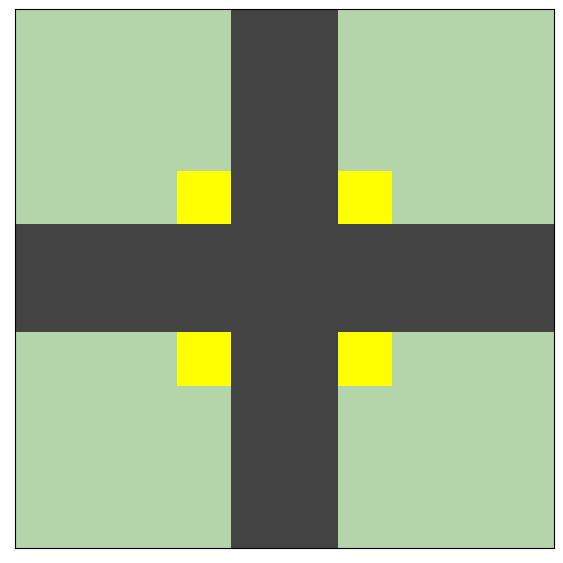

In [16]:
cmap = ListedColormap([(139/255, 0, 139/255), (0, 0, 1), (139/255, 69/255, 19/255), (1, 165/255, 0), 
                       (0, 1, 0), (1, 1, 0), (1, 0, 0), (67/255, 67/255, 67/255), (180/255, 213/255, 170/255)])
bounds = [0,1,2,3,4,5,6,7,8,9]
norm = BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap, norm)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))
anim
